# U-Net for Image Segmentation
Implementation of the U-Net model for segmenting medical images.


# Import necessary libraries


In [ ]:
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Task 1: Implementing the Double Convolution Block

The double convolution block is a core component of the U-Net architecture, consisting of two sets of convolutional and ReLU activation layers. This structure helps in learning more complex features at each level of the network without reducing the spatial dimensions of the feature maps.

**Objective:** Implement the `double_convolution` function that takes input channels and output channels as parameters and returns a sequential container of two convolution layers each followed by a ReLU activation.

In [ ]:
# class DoubleConv(nn.Module):
#   def __init__(self,in_channels,out_channels):
#     super(self).__init__()
#     self.conv1 = nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#         nn.ReLU,
#         nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#         nn.ReLU
#     )

#     def forward(self,x):
#       return self.conv1(x)

In [ ]:
def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )
    return conv_op

### Task 2: Implementing the U-Net Architecture

Building upon the double convolution block you implemented, your next challenge is to complete the architecture of U-Net. U-Net is a symmetric architecture with an encoder (contracting path), a bottleneck, and a decoder (expansive path). It also features skip connections that help recover spatial information lost during down-sampling.

**Objective:** Complete the implementation of the `UNet` class by adding the necessary components for the encoder and decoder sections.


#### Hints for Completing the U-Net Architecture

1. **Encoder Details:**
   - Each level in the encoder consists of a `double_convolution` followed by a `max_pool2d`. You have already defined the first two levels. Continue this pattern for the next two levels, increasing the number of channels appropriately (e.g., 256 for the third, 512 for the fourth).

2. **Bottleneck:**
   - The bottleneck does not include pooling and directly connects to the deepest layer of the encoder.

3. **Decoder Details:**
   - Each level of the decoder starts with a transpose convolution (`nn.ConvTranspose2d`) to upsample the feature map followed by a `double_convolution`. Remember to concatenate the upsampled output with the feature map from the corresponding encoder level using `torch.cat`. This is crucial for forming the skip connections that help the network learn precise localization.

4. **Output Size:**
   - Ensure the final layer reduces the number of channels to the number of classes. This is typically done with a 1x1 convolution.

5. **Forward Method:**
   - The forward method must meticulously chain all these operations ensuring the tensors are correctly sized for each operation. Debugging tips: Print the shape of tensors at each step if unsure.

6. **Skip Connections:**
   - For each layer in the decoder, use the output from the corresponding encoder layer. This helps in recovering the spatial information lost during downsampling.


In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_convolution_4 = double_convolution(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], dim=1))

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], dim=1))

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], dim=1))

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], dim=1))

        out = self.out(x)
        return out


num_classes = 1
model = UNet(num_classes=num_classes)

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
summary(model=model,input_size = (1,3,224,224),)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 224, 224]          --
├─Sequential: 1-1                        [1, 64, 224, 224]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
├─MaxPool2d: 1-2                         [1, 64, 112, 112]         --
├─Sequential: 1-3                        [1, 128, 112, 112]        --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-6                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-7                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-8                         [1, 128, 112, 112]        --
├─MaxPool2d: 1-4                         [1, 128, 56, 56]          --

## Dataset Preparation
Using the Brain Tumor Dataset, which is annotated in COCO format. The dataset class loads images and corresponding segmentation masks.


In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.ann_file = os.path.join(root_dir, '_annotations.coco.json')
        self.coco = COCO(self.ann_file)
        self.transform = transform
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Create mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        if self.transform is not None:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert mask to tensor and add channel dimension

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define dataset and dataloader
root_dir = '/content/drive/MyDrive/Brain Tumor Kaggle Dataset/valid'  # Directory containing all the images and the annotations.json file

dataset = BrainTumorDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

loading annotations into memory...
Done (t=2.46s)
creating index...
index created!


## Training the U-Net Model
Training the U-Net model on the Brain Tumor Dataset. The training loop involves feeding the images through the model, computing the loss, and updating the model weights.


In [ ]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training setup
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

print("Training finished.")

KeyboardInterrupt: 

## Visualizing Results
We will visualize some sample images and their corresponding predicted masks to see how well the model performs.


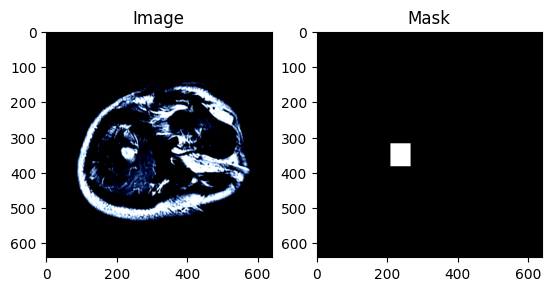

In [ ]:
# Function to display an image and its mask
def show_sample(image, mask):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax[0].set_title('Image')
    ax[1].imshow(mask.squeeze(0), cmap='gray')  # Remove the channel dimension
    ax[1].set_title('Mask')
    plt.show()

# Check a sample
data_iter = iter(dataloader)
images, masks = next(data_iter)
show_sample(images[0], masks[0])